In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from alphatoe import plot, game, data
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from functools import partial
from copy import copy
import tqdm
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
weights = torch.load("../scripts/models/prob all 8 layer control-20230718-185339.pt")
with open("../scripts/models/prob all 8 layer control-20230718-185339.json", "r") as f:
    args = json.load(f)

In [3]:
model_cfg = HookedTransformerConfig(
    n_layers=args["n_layers"],
    n_heads=args["n_heads"],
    d_model=args["d_model"],
    d_head=args["d_head"],
    d_mlp=args["d_mlp"],
    act_fn=args["act_fn"],
    normalization_type=args["normalization_type"],
    d_vocab=11,
    d_vocab_out=10,
    n_ctx=10,
    init_weights=True,
    device=args["device"],
    seed=args["seed"],
)
model = HookedTransformer(model_cfg)
model.load_state_dict(weights)

<All keys matched successfully>

In [4]:
neurons = [5, 117, 160, 195, 248, 342, 384]
loss_fn = F.cross_entropy


def get_neuron_acts(model, seq):
    with torch.no_grad():
        logits, cache = model.run_with_cache(torch.tensor(seq))
    neuron_activations = copy(cache["post", 0][0])
    return neuron_activations


def ablate_one_neuron(neuron, seq):
    def hook(module, input, output):
        result = output.clone()
        result[:, :, neuron] = 0
        return result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        logits = model(torch.tensor(seq))
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return logits


def neuron_ablated_loss(data, neuron):
    data_size = data.shape[0]
    target = einops.repeat(
        torch.tensor([0.0] * 9 + [1.0]),
        "logit_dim -> data_size logit_dim",
        data_size=data_size,
    ).to("cuda")
    logits = ablate_one_neuron(neuron, data)[:, -1, :]
    loss = F.cross_entropy(logits, target, reduction="none")
    loss.to("cpu").detach().numpy()
    return loss

In [5]:
df = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
# count uniques in df
first_conditions = Counter(df["first win condition"])
second_conditions = Counter(df["second win condition"])
for key, val in (first_conditions + second_conditions).items():
    if isinstance(key, str):
        print(f"{key}: {val}")

left column: 24228
top left -> bottom right: 38196
top row: 24228
middle column: 24228
bottom left -> top right: 38196
right column: 24228
middle row: 24228
bottom row: 24228


/tmp/ipykernel_108025/4271538171.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")


In [6]:
df.head()

,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [7]:
# long run time
batch_restarts = (
    [0]
    + [df.loc[df["steps till end state"] == i].index[0] for i in [6, 7, 8, 9]]
    + [len(df)]
)
batch_size = 4096
neurons = list(range(512))
df_ablation_losses = pd.DataFrame(columns=["moves played"] + neurons)
with torch.no_grad():
    for neuron in neurons:
        neuron_losses = []
        for j in range(len(batch_restarts) - 1):
            batch_size = min(batch_restarts[j + 1], batch_size)
            batch_size = 4096
            for i in range(batch_restarts[j], batch_restarts[j + 1], batch_size):
                batch_size = 4096
                batch_gap = batch_restarts[j + 1] - i
                batch_size = batch_gap if batch_gap < batch_size else batch_size
                games = torch.stack(
                    [
                        torch.tensor([10] + eval(game))
                        for game in df["moves played"].iloc[i : i + batch_size]
                    ]
                ).to("cuda")
                loss = neuron_ablated_loss(games, neuron)
                neuron_losses.append(loss)
        inter = [
            loss.item()
            for loss in torch.cat(
                [torch.flatten(batch_losses) for batch_losses in neuron_losses]
            )
        ]

        df_ablation_losses[neuron] = inter

/tmp/ipykernel_108025/1016717474.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))


In [8]:
df.head()

,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [9]:
df_ablation_losses["first win condition"] = df["first win condition"]
df_ablation_losses["moves played"] = df["moves played"]

/tmp/ipykernel_108025/282691839.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ablation_losses["first win condition"] = df["first win condition"]


In [10]:
df_ablation_losses = df_ablation_losses.copy()

In [11]:
# save csv
df_ablation_losses.to_csv("../data/230801_mlp_neuron_ablations.csv", index=False)

In [12]:
df_ablation_losses = pd.read_csv("../data/230801_mlp_neuron_ablations.csv")

In [13]:
df_ablation_losses.head()

,moves played,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,first win condition
0,"[0, 1, 3, 2, 6]",0.000008,0.000008,0.000497,0.000010,1.311301e-06,1.097598,0.000004,0.000005,0.000002,...,3.576278e-07,0.000003,0.000004,0.000002,0.000005,0.000006,0.000008,0.000051,0.000006,left column
1,"[0, 1, 3, 4, 6]",0.000195,0.000189,0.036626,0.000232,3.099437e-06,3.076246,0.000077,0.000098,0.000029,...,1.215927e-05,0.000041,0.000081,0.000042,0.000100,0.000123,0.000181,0.000794,0.000149,left column
2,"[0, 1, 3, 5, 6]",0.000011,0.000011,0.000807,0.000013,4.768370e-07,1.423352,0.000005,0.000005,0.000003,...,8.344647e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000010,0.000073,0.000009,left column
3,"[0, 1, 3, 7, 6]",0.000015,0.000014,0.002130,0.000017,8.344647e-07,1.009676,0.000005,0.000007,0.000003,...,7.152555e-07,0.000003,0.000005,0.000004,0.000008,0.000008,0.000012,0.000072,0.000010,left column
4,"[0, 1, 3, 8, 6]",0.000022,0.000021,0.001409,0.000025,8.344647e-07,1.193812,0.000010,0.000010,0.000005,...,8.344647e-07,0.000008,0.000009,0.000005,0.000012,0.000013,0.000019,0.000130,0.000016,left column


In [14]:
df_ablation_losses.drop("", axis=1, inplace=True)

KeyError: "[''] not found in axis"

In [15]:
df_ablation_losses.head()

,moves played,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,first win condition
0,"[0, 1, 3, 2, 6]",0.000008,0.000008,0.000497,0.000010,1.311301e-06,1.097598,0.000004,0.000005,0.000002,...,3.576278e-07,0.000003,0.000004,0.000002,0.000005,0.000006,0.000008,0.000051,0.000006,left column
1,"[0, 1, 3, 4, 6]",0.000195,0.000189,0.036626,0.000232,3.099437e-06,3.076246,0.000077,0.000098,0.000029,...,1.215927e-05,0.000041,0.000081,0.000042,0.000100,0.000123,0.000181,0.000794,0.000149,left column
2,"[0, 1, 3, 5, 6]",0.000011,0.000011,0.000807,0.000013,4.768370e-07,1.423352,0.000005,0.000005,0.000003,...,8.344647e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000010,0.000073,0.000009,left column
3,"[0, 1, 3, 7, 6]",0.000015,0.000014,0.002130,0.000017,8.344647e-07,1.009676,0.000005,0.000007,0.000003,...,7.152555e-07,0.000003,0.000005,0.000004,0.000008,0.000008,0.000012,0.000072,0.000010,left column
4,"[0, 1, 3, 8, 6]",0.000022,0.000021,0.001409,0.000025,8.344647e-07,1.193812,0.000010,0.000010,0.000005,...,8.344647e-07,0.000008,0.000009,0.000005,0.000012,0.000013,0.000019,0.000130,0.000016,left column


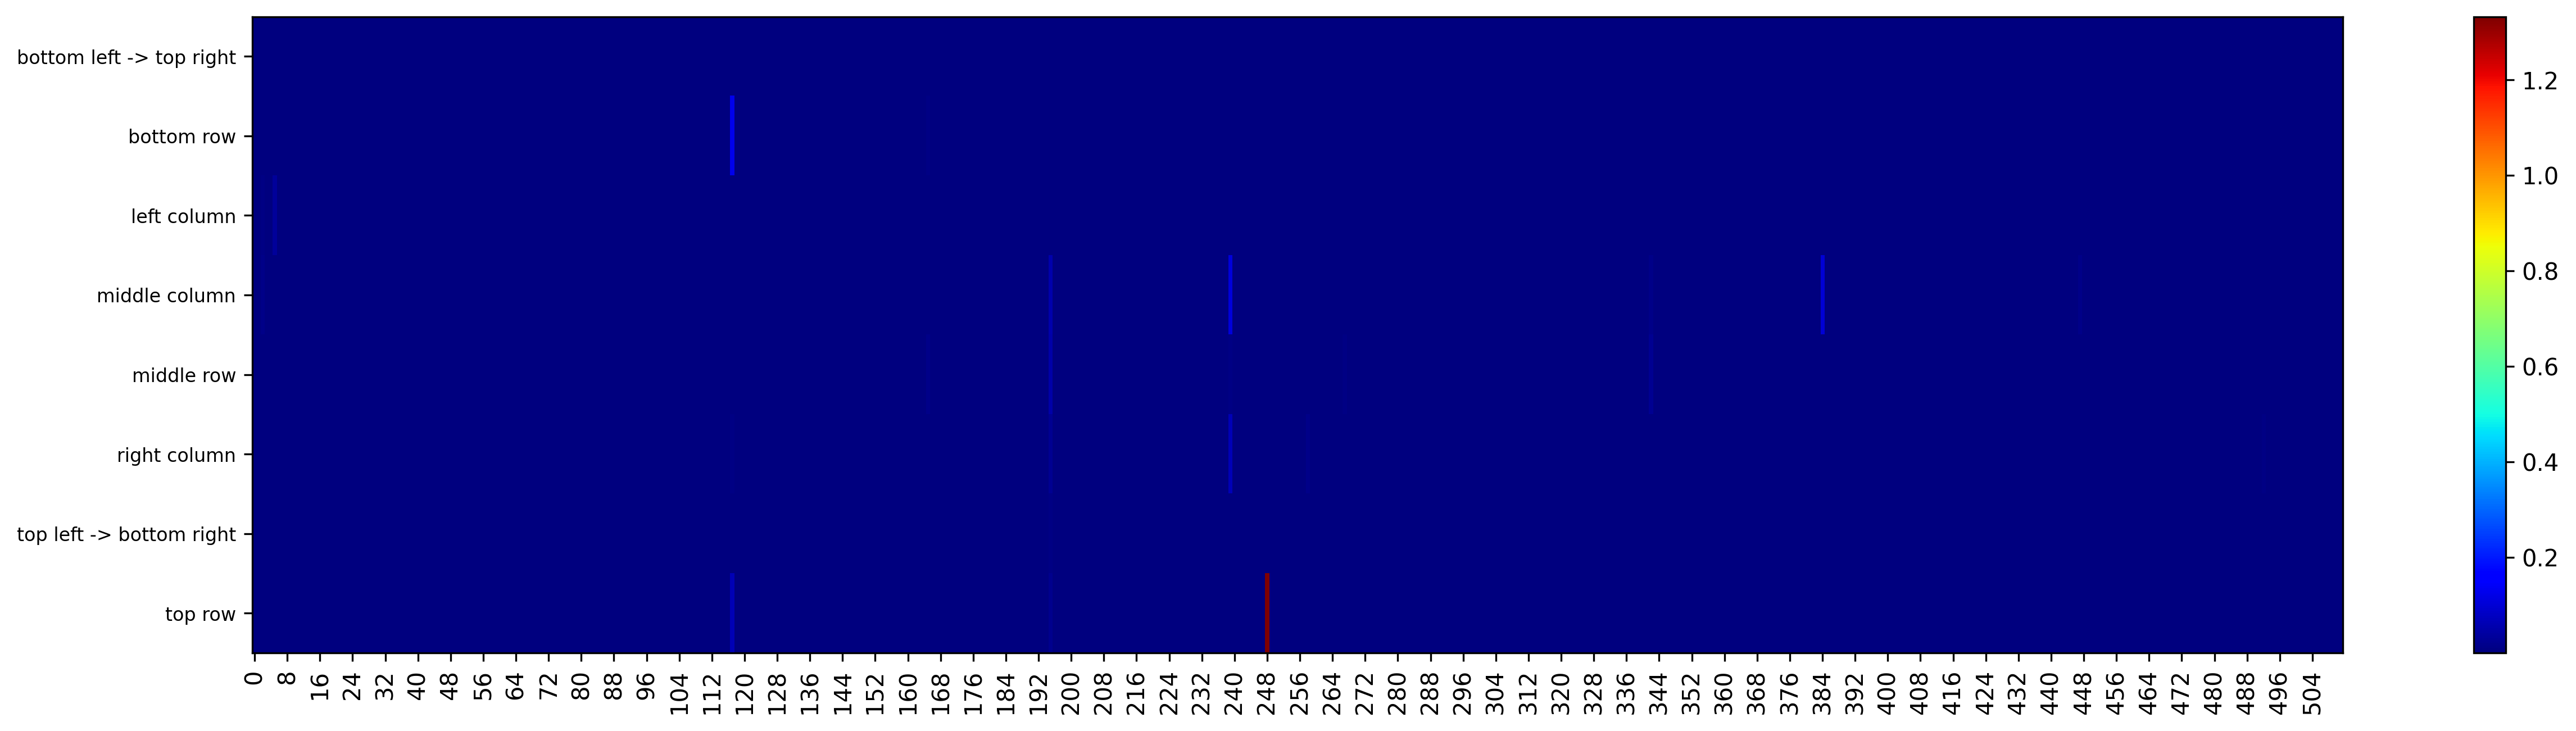

In [39]:
#figure size
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 300
grouped = df_ablation_losses.groupby(["first win condition"])
plt.imshow(grouped.mean(), cmap="jet", interpolation="nearest",aspect='auto')
plt.colorbar()
# legend
plt.xticks(np.arange(0, 512, 8), labels=grouped.mean().columns[::8]);
# yticks
plt.yticks(np.arange(0, 8), labels=grouped.mean().index);
#y tick size
plt.tick_params(axis='y', which='major', labelsize=8)
#tilt x ticks
plt.xticks(rotation=90);

In [ ]:
grouped.mean().shape

(8, 512)

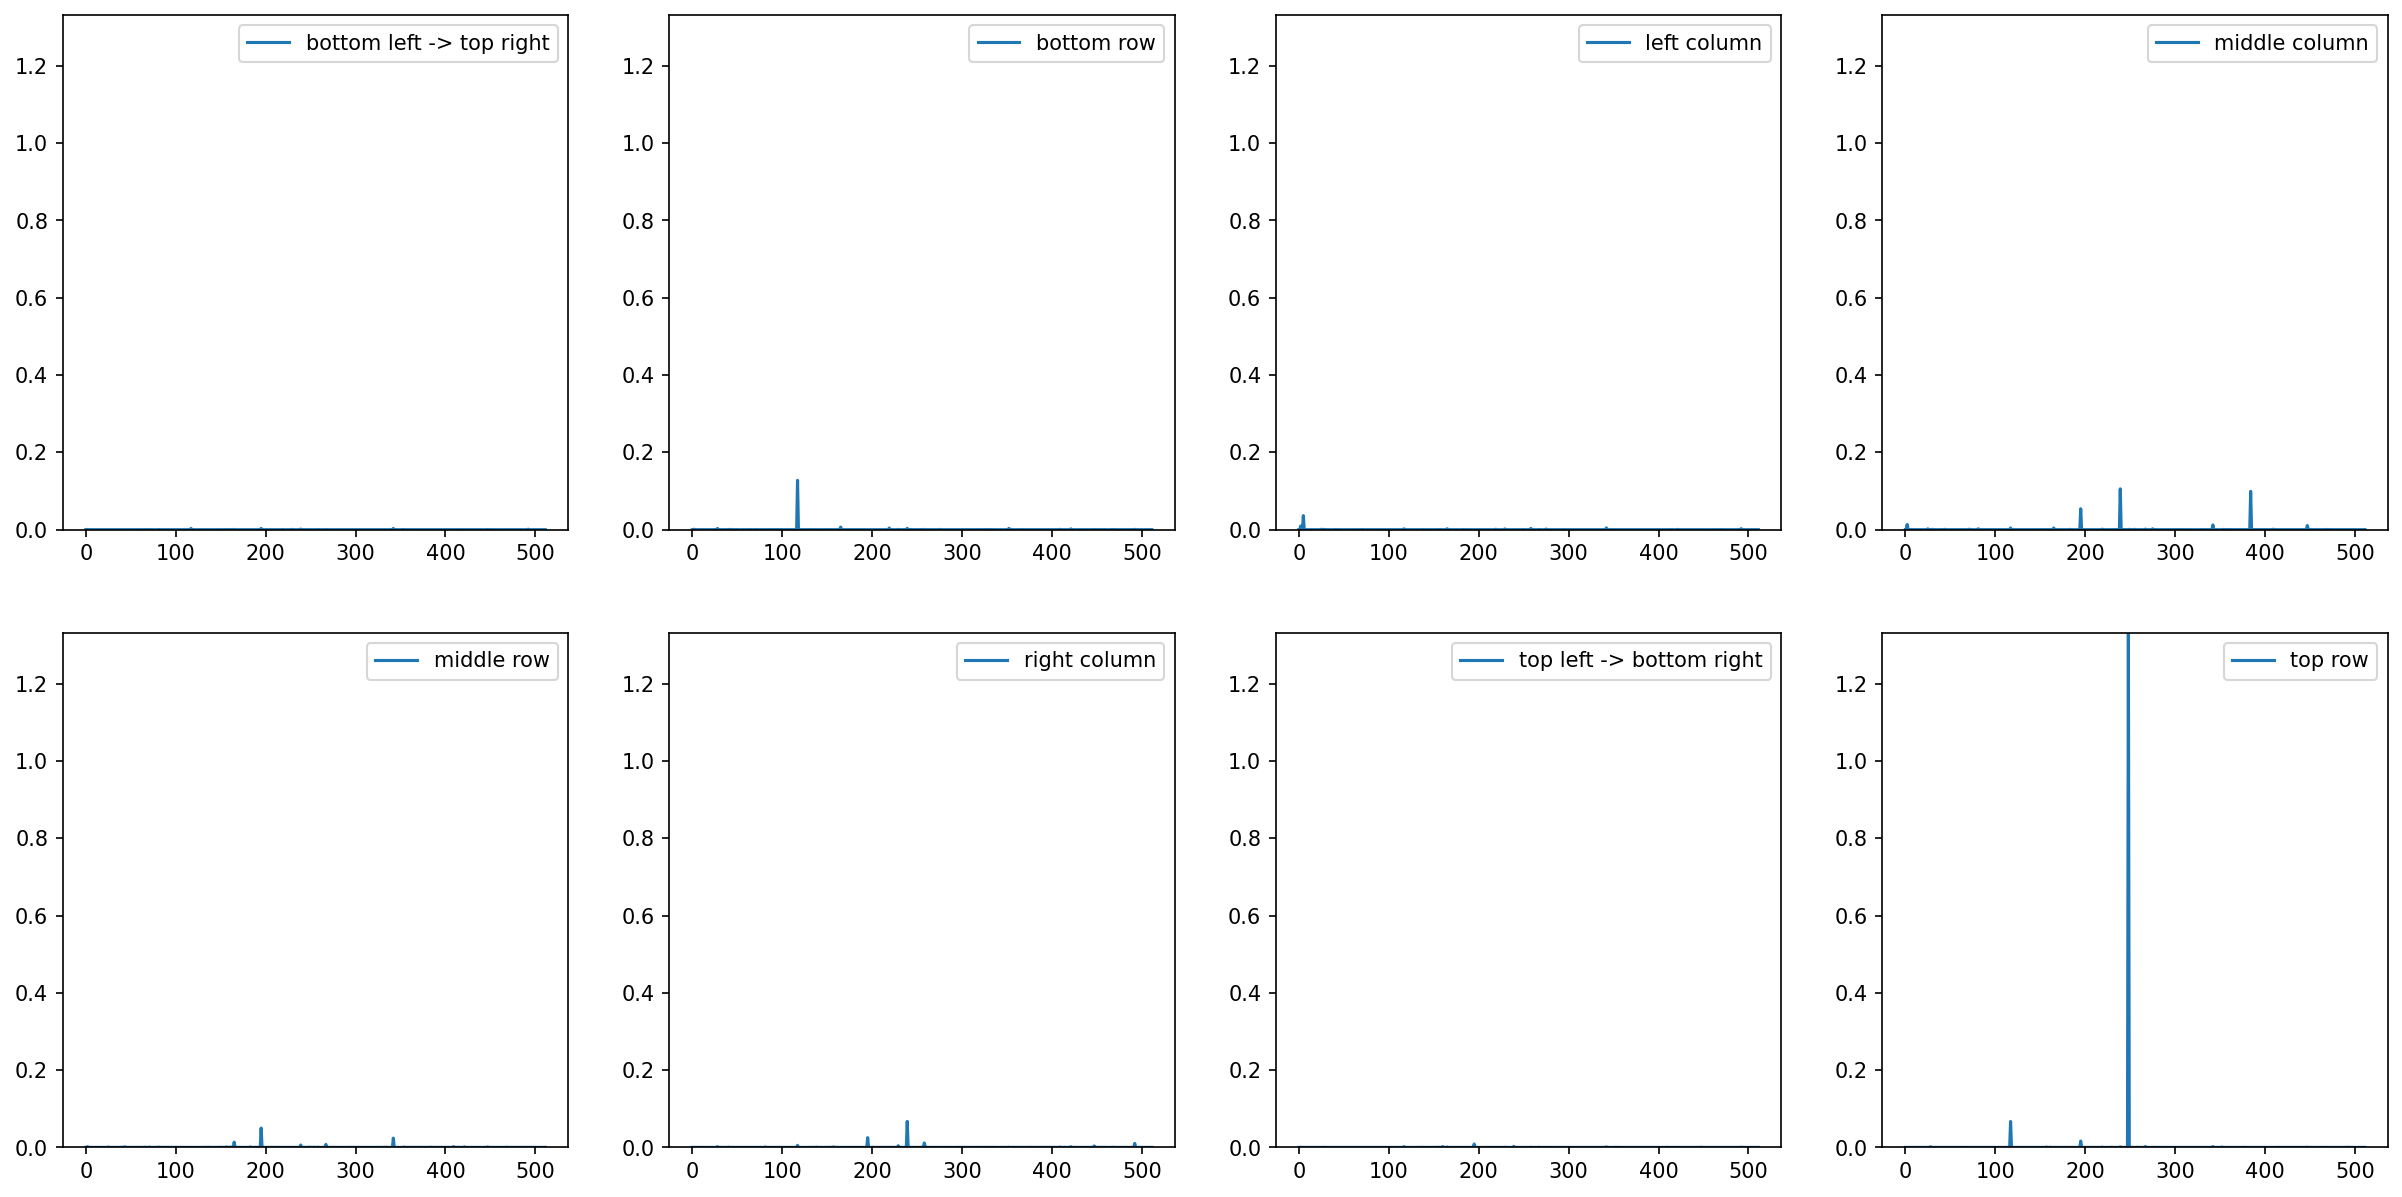

In [17]:
plt.figure(figsize=(20, 10))
data = grouped.mean()
mv = data.to_numpy().max()
labels = data.index.to_list()
for i, row in enumerate(data.to_numpy()):
    # print(row)
    plt.subplot(2, 4, i + 1)
    plt.plot(row, label=labels[i])
    plt.ylim(0, mv)
    plt.legend()

In [ ]:
print(grouped.mean())

                                 0         1         2         3         4   
first win condition                                                          
bottom left -> top right  0.000048  0.000060  0.000726  0.000063  0.000035  \
bottom row                0.000094  0.000161  0.001099  0.000112  0.000052   
left column               0.000065  0.000066  0.009341  0.000074  0.000035   
middle column             0.000129  0.000109  0.013388  0.000141  0.000063   
middle row                0.000154  0.000163  0.001953  0.000165  0.000042   
right column              0.000087  0.000123  0.000085  0.000099  0.000085   
top left -> bottom right  0.000044  0.000048  0.000521  0.000046  0.000016   
top row                   0.000046  0.000040  0.000205  0.000052  0.000040   

                                 5         6         7         8         9   
first win condition                                                          
bottom left -> top right  0.000047  0.000027  0.000038  0.00000